In [1]:
import pandas as pd

data = pd.read_csv("../database/mergedData/Annual_V.csv", index_col=[0])
wigs = pd.read_csv("../database/gpwCompaniesLists/WIGs.csv")

In [248]:
data.loc[data["Ticker"] == "FRO"]

,Ticker,Data,Przychody ze sprzedaży,Techniczny koszt wytworzenia produkcji sprzedanej,Koszty sprzedaży,Koszty ogólnego zarządu,Zysk ze sprzedaży,Pozostałe przychody operacyjne,Pozostałe koszty operacyjne,Zysk operacyjny (EBIT),...,Rozliczenia międzyokresowe,Pasywa razem,Przepływy pieniężne z działalności operacyjnej,Amortyzacja,Przepływy pieniężne z działalności inwestycyjnej,CAPEX (niematerialne i rzeczowe),Przepływy pieniężne z działalności finansowej,Emisja akcji,Dywidenda,Przepływy pieniężne razem
1077,FRO,2010-04-29,166098.0,142942.0,0.0,0.0,23156.0,522.0,10642.0,13036.0,...,0.0,127553.0,-11662.0,974.0,501.0,767.0,7303.0,9613.0,0.0,-3858.0
1078,FRO,2011-03-03,259793.0,208441.0,0.0,0.0,51352.0,945.0,18722.0,33575.0,...,0.0,348229.0,27313.0,1800.0,-135870.0,1528.0,111383.0,85559.0,0.0,2826.0
1079,FRO,2012-03-15,276085.0,228745.0,0.0,0.0,47340.0,1503.0,20721.0,28122.0,...,0.0,344122.0,29766.0,2094.0,-1537.0,1756.0,-24948.0,0.0,6355.0,3281.0
1080,FRO,2013-03-13,270197.0,218461.0,0.0,0.0,51736.0,1181.0,20032.0,32885.0,...,0.0,324725.0,57604.0,2106.0,-1176.0,1316.0,-35991.0,0.0,5071.0,20437.0
1081,FRO,2014-03-20,270745.0,213229.0,0.0,0.0,57516.0,1558.0,21086.0,37988.0,...,0.0,320717.0,-14030.0,2103.0,11065.0,2842.0,-42156.0,1615.0,21167.0,-45121.0
1082,FRO,2015-03-19,292100.0,238342.0,0.0,0.0,53758.0,1594.0,22335.0,33017.0,...,0.0,321024.0,31331.0,2191.0,-1817.0,1930.0,-19296.0,0.0,21243.0,10218.0
1083,FRO,2016-03-10,332490.0,266328.0,0.0,0.0,66162.0,1675.0,26716.0,41121.0,...,0.0,341581.0,34183.0,4813.0,-3203.0,3245.0,-27551.0,0.0,15932.0,3429.0
1084,FRO,2017-03-21,364679.0,288429.0,0.0,0.0,76250.0,2403.0,30905.0,47748.0,...,0.0,365182.0,53232.0,3881.0,-4252.0,4380.0,-27286.0,0.0,25491.0,21694.0
1085,FRO,2018-04-17,405571.0,318331.0,0.0,0.0,87240.0,1889.0,35571.0,53558.0,...,0.0,390875.0,-25108.0,3727.0,-7079.0,7239.0,5250.0,0.0,7435.0,-26937.0
1086,FRO,2019-03-29,451257.0,354564.0,0.0,0.0,96693.0,2251.0,38342.0,60602.0,...,0.0,411649.0,54557.0,6255.0,-4407.0,4634.0,-51921.0,0.0,23792.0,-1771.0


## Założenia 

Dla każdego raportu (daty publikacji) pozyskujemy zestawienie wycen na każdy dzień

$t_0$ - data publikacji sprawozdania finansowego

$t_{-60}...t_{+15}$


In [188]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

class SmoothingFilters:
    @staticmethod
    def exponentialMovingAverage(x_data : np.ndarray, span : float = None, alpha : float = None) -> np.ndarray:
        return (pd.DataFrame({"x":x_data}).ewm(span=span, alpha=alpha).mean()["x"].to_numpy())

    @staticmethod
    def savgolFilter(x_data : np.ndarray, window_length : int, poly_order : int) -> np.ndarray:
        return savgol_filter(x_data, window_length, poly_order)


class IndexReturn:
    PATH_2_HISTORICAL = "../database/indexHistorical/"
    
    def __init__(self) -> None:
        self.historical_data : pd.DataFrame = None
        self.price_type :str = "Close"

    def readHistorical(self, wig_ticker : str) -> None:
        self.historical_data = pd.read_csv(f"{IndexReturn.PATH_2_HISTORICAL}{wig_ticker}.csv")
        # Cast to yahoo finance format 
        self.historical_data["Data"] = self.historical_data["Data"].apply(lambda x : pd.to_datetime(np.datetime64(x)))
        self.historical_data.set_index("Data", inplace=True, drop=True)
        self.historical_data.index.names = ['Date']
        self.historical_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    #def getDailyReturn(self, start : np.datetime64, end : np.datetime64) -> np.ndarray:
        #historical = self.historical_data[(self.historical_data.index >= start-1) &
        #                                  (self.historical_data.index <  end)]
    def getDailyReturn(self, t0 : np.datetime64, pre_offset : int, post_offset) -> np.ndarray:    
        post_historical = self.historical_data[(self.historical_data.index < t0)][-post_offset:]
        pre_historical = self.historical_data[(self.historical_data.index >= t0)][:pre_offset]
        historical = pd.merge(post_historical, pre_historical, how="outer")

        historical_price = historical[self.price_type].to_numpy()

        historical_date   = historical.index[1:]
        historical_return = (historical_price[1:] - historical_price[:-1]) / historical_price[:-1]

        return pd.DataFrame({"IndexReturn": historical_return},
                            index=historical_date)
        
    def getHistorical(self) -> pd.DataFrame:
        return self.historical_data 
    

class CompanyReturn:
    POSTFIX = ".WA"
    PATH_2_WIGS = "../database/gpwCompaniesLists/WIGs.csv"

    def __init__(self):
        self.historical_data : pd.DataFrame = None
        self.price_type :str = "Close"
        self.wigs = pd.read_csv(CompanyReturn.PATH_2_WIGS)

    def readHistorical(self, company_ticker : str) -> None:
        yf_handler = yf.Ticker(company_ticker+CompanyReturn.POSTFIX)
        self.historical_data = yf_handler.history(period="max", interval="1d")
        self.historical_data.index = list(map(lambda x : np.datetime64(str(x)[:10]), 
                                              self.historical_data.index))

    def getDailyReturn(self, t0 : np.datetime64, pre_offset : int, post_offset) -> np.ndarray:
        post_historical = self.historical_data[(self.historical_data.index < t0)][-post_offset:]
        pre_historical = self.historical_data[(self.historical_data.index >= t0)][:pre_offset]
        historical = pd.merge(post_historical, pre_historical, how="outer")

        historical_price = historical[self.price_type].to_numpy()

        historical_date   = historical.index[1:]
        historical_return = (historical_price[1:] - historical_price[:-1]) / historical_price[:-1]

        return pd.DataFrame({"CompanyReturn": historical_return},
                            index=historical_date)
    
    def getIndexTick(self, company_ticker : str) -> str:
        return self.wigs.columns[self.wigs.isin([company_ticker]).any()].to_list()[0]

### Code example

In [286]:
TICKER = "FRO"
cr = CompanyReturn()
ir = IndexReturn()

t0 = np.datetime64("2018-04-17")
PRE_OFFSET = 30
POST_OFFSET = 30


cr.readHistorical(TICKER)
company_daily_return =cr.getDailyReturn(t0-PRE_OFFSET, t0+POST_OFFSET)
ir.readHistorical(cr.getIndexTick(TICKER))
index_daily_return = ir.getDailyReturn(t0-PRE_OFFSET, t0+POST_OFFSET) 

result = pd.merge(company_daily_return, index_daily_return, left_index=True, right_index=True, how='inner')

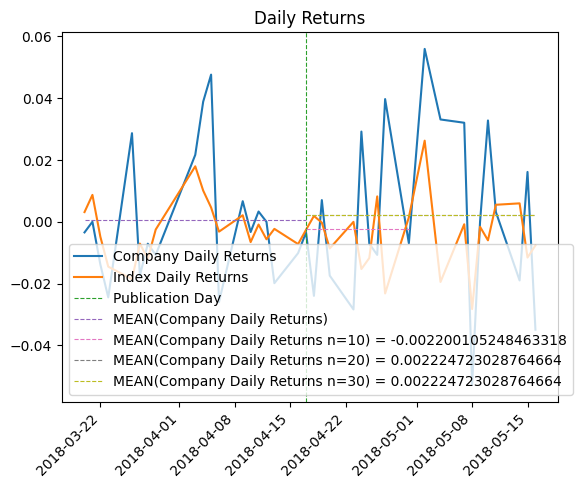

In [287]:
import matplotlib.pyplot as plt

N_PERIOD = 3
MEAN_POST_PERIOD = np.arange(1, N_PERIOD+1) * POST_OFFSET//N_PERIOD

plt.plot(result.index, result["CompanyReturn"], color = "C0", label= "Company Daily Returns")
plt.plot(result.index, result["IndexReturn"], color = "C1",  label= "Index Daily Returns")
plt.axvline(x=t0, color="C2", linestyle='--', linewidth=0.8, label= "Publication Day")
plt.hlines(np.mean(result[result.index < t0]["CompanyReturn"]), result.index[0], t0, color="C4", 
           linestyle='--', linewidth=0.8, label= "MEAN(Company Daily Returns)")
for i, period in enumerate(MEAN_POST_PERIOD):
    period_result = result[result.index >= t0][:period]
    period_mean = np.mean(period_result["CompanyReturn"])
    plt.hlines(period_mean, period_result.index[0], period_result.index[-1], 
               linestyle='--', color=f"C{i+6}", linewidth=0.8, label= f"MEAN(Company Daily Returns n={period}) = {period_mean}")

plt.xticks(rotation=45, ha='right')
plt.legend(loc="lower left")
plt.title("Daily Returns")
plt.show()


In [303]:
result[result.index >= t0]

,CompanyReturn,IndexReturn
2018-04-17,-0.003413,-0.002600
2018-04-18,-0.023973,0.001886
2018-04-19,0.007018,-0.000266
2018-04-20,-0.017422,-0.008616
2018-04-23,-0.028369,-0.000019
2018-04-24,0.029197,-0.015293
2018-04-25,-0.007092,-0.011726
2018-04-26,-0.010714,0.008215
2018-04-27,0.039711,-0.023199
2018-04-30,-0.006944,0.001453


In [261]:
MEAN_POST_PERIOD

array([10, 20, 30])

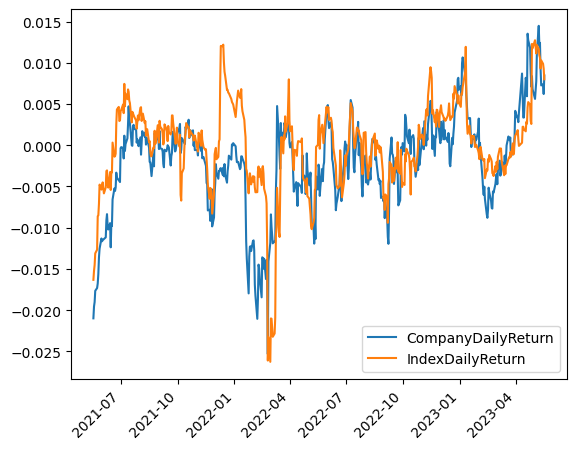

In [97]:
plt.plot(result.index, result["CompanyReturn"].ewm(span=30, adjust=False).mean().to_list(), label= "CompanyDailyReturn")
plt.plot(result.index, result["IndexReturn"].ewm(span=30, adjust=False).mean().to_list(),  label= "IndexDailyReturn")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()



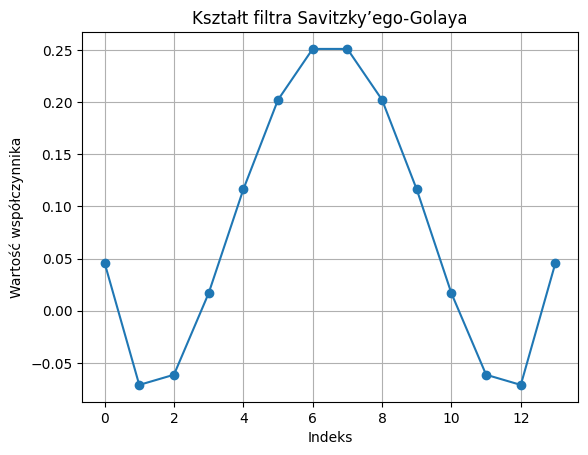

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_coeffs, savgol_filter

# Parametry filtra
window_length = 14  # Długość okna, musi być nieparzysta
polyorder = 4       # Rząd wielomianu

# Oblicz współczynniki filtra
coeffs = savgol_coeffs(window_length, polyorder)

# Wizualizacja kształtu filtra
plt.plot(coeffs, marker='o')
plt.title('Kształt filtra Savitzky’ego-Golaya')
plt.xlabel('Indeks')
plt.ylabel('Wartość współczynnika')
plt.grid(True)
plt.show()

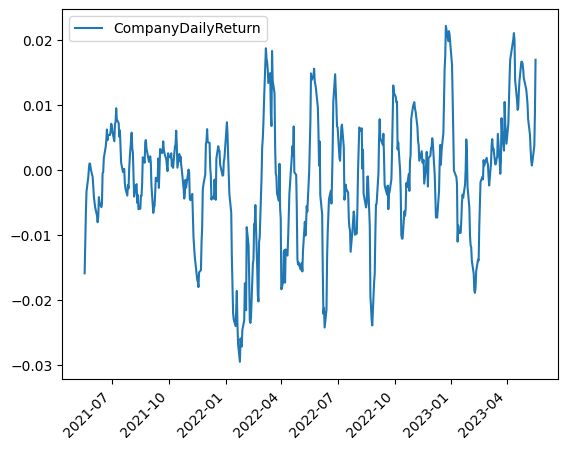

In [94]:
plt.plot(result.index, savgol_filter(result["CompanyReturn"], 30, 5), label= "CompanyDailyReturn")
#plt.plot(result.index, result["CompanyReturn"], label= "RawCompanyDailyReturn")
#plt.plot(result.index, result["IndexReturn"].ewm(span=12, adjust=False).mean().to_list(),  label= "IndexDailyReturn")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

In [347]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


model = LinearRegression()
x = index_daily_return.reshape(-1, 1)
y = daily_return.reshape(-1, 1)
model.fit(x,y)
y_pred = model.predict(x)
print('coefficients: ', model.coef_)
print('intercept: ', model.intercept_)
print('Root Mean Squared Error (RMSE): %.2f'% np.sqrt(mean_squared_error(y, y_pred)))
print('Coefficient of determination: %.2f'% r2_score(y, y_pred))

coefficients:  [[0.90695405]]
intercept:  [-0.00081518]
Root Mean Squared Error (RMSE): 0.02
Coefficient of determination: 0.66
